In [1]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.ticker as tck
from scipy.ndimage import gaussian_filter1d
import sys
sys.path.append("..")
from src import *

2024-06-07 17:05:02.759278: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-07 17:05:02.829213: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 17:05:04.004399: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


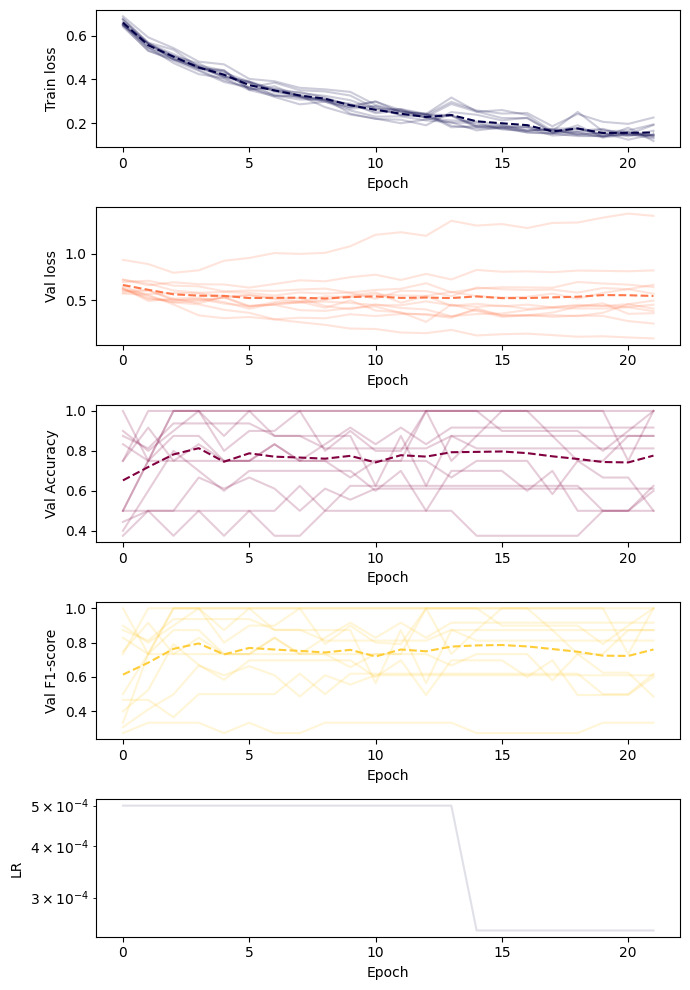

In [2]:
#sns.set_theme("paper")
runs_path = "../src/model/runs/conv1_only"
models = [m for m in sorted(os.listdir(runs_path)) if not m.startswith(".")]
palette = {"Training loss": "#030047",	"Validation loss":"#FF784B", "Validation accuracy":"#800040", "Validation F1-score":"#FFCD38", "Learning rate": "#676690"}
signal_length = 22
f, axs = plt.subplots(5, 1, figsize=(7, 10))
#for j in range(1, len(models)):
#    axs[j, -1].sharey(axs[0, -1])
#    axs[j, 1].sharey(axs[0, 1])

signals = np.ndarray((len(models), 5, signal_length))

for j, m in enumerate(models):
    run = os.listdir(os.path.join(runs_path, m))[-1]
    fp = os.path.join(runs_path, m, run)
    if os.path.isdir(fp):
        continue
    for i, observed_value in enumerate(["Train loss", "Val loss", "Val Accuracy", "Val F1-score", "LR"]):

        y, x = get_scalar_run_tensorboard(observed_value, fp)
        
        signals[j, i] = y[:signal_length]
        axs[i].set_xlabel("Epoch")
        axs[i].set_ylabel(observed_value)
        #axs[i].plot(x[:35], gaussian_filter1d(y[:35], 2), label=list(palette.keys())[i], c=palette[list(palette.keys())[i]], alpha=0.2)
        if i == 4: 
            if j != 0:
                continue
        axs[i].plot(x[:signal_length], y[:signal_length], label=list(palette.keys())[i], c=palette[list(palette.keys())[i]], alpha=0.2)
        axs[i].xaxis.set_major_locator(tck.MultipleLocator(5))

        if i == 4:
            #axs[j, i // 2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
            axs[i].set_yscale("log")
        if j == len(models) - 1 and i != 4:
            axs[i].plot(range(signal_length), np.mean(signals, axis=0)[i], label=list(palette.keys())[i], c=palette[list(palette.keys())[i]], linestyle="--")
                
#legend_handles = [Patch(color=color, label=key) for key, color in palette.items()]
#plt.figlegend(handles=legend_handles, loc="upper center", ncol=5, frameon=False)

plt.tight_layout()
plt.savefig("./training_process.png")

In [3]:
splits = {
    0: ['B276', 'B295'],
    1: ['B421', 'B340'],
    2: ['B273', 'B488', 'B487'],
    3: ['B294', 'B513'],
    4: ['B369', 'B518', 'B515'],
    5: ['B034', 'B397'],
    6: ['B289', 'B274'],
    7: ['B302', 'B148'],
    8: ['B406', 'B405', 'B407'],
    9: ['B492', 'B023'],
    10: ['B423', 'B424', 'B497'],
    11: ['B391', 'B502', 'B503']
}

In [4]:
data = get_data_csv(high_quality_only=False, pfs=False, config_path=os.path.join("/data_nfs", "je30bery/melanoma_data/config.json"))
data = data.reset_index().drop("index", axis=1)
data = data[data["Histo-ID"].isin([v for l in splits.values() for v in l])]
models_split_ids = [int(m[50:-21]) for m in models]
weights = [len(data[data["Histo-ID"].isin(splits[id])]) for id in models_split_ids]
weights

[2, 6, 8, 2, 4, 4, 4, 4, 5, 5, 6, 6]

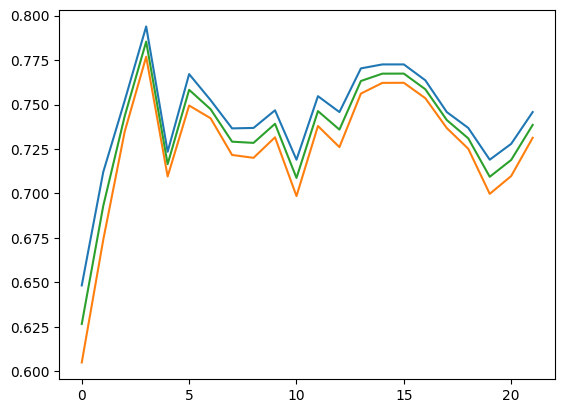

In [5]:
acc = np.average(signals[:, 2], axis=0, weights=weights)
f1 = np.average(signals[:, 3], axis=0, weights=weights)
val_loss = np.average(signals[:, 4], axis=0, weights=weights)
performance = 1/2*(acc +f1)
plt.plot(acc)
plt.plot(f1)
plt.plot(performance)

In [6]:
print("Minimal average validation loss at epoch:", np.argmin(val_loss), np.min(val_loss), performance[np.argmin(val_loss)])
print("Maximal average performance at epoch:", np.argmax(performance), np.max(performance))

Minimal average validation loss at epoch: 14 0.00020714286620204803 0.7673777969820159
Maximal average performance at epoch: 3 0.7853899135121278


In [7]:
old
->

SyntaxError: invalid syntax (4102674515.py, line 2)

In [ ]:
sns.set_theme("paper")
models = ["ResNet_1e-4_2,3_frozen", "vgg_lr=1e-4", "effnet_3:5_frozen_lr=1e-3", "tumor_stage_classifier"]
palette = {"Training loss": "#030047",	"Validation loss":"#FF784B", "Validation accuracy":"#800040", "Validation F1-score":"#FFCD38", "Learning rate": "#676690"}

f, axs = plt.subplots(len(models), 3, figsize=(7, 10))
for j in range(1, len(models)):
    axs[j, -1].sharey(axs[0, -1])
    axs[j, 1].sharey(axs[0, 1])

for j, m in enumerate(models):
    run = os.listdir(f"../data/models/{m}")[-1]
    fp = os.path.join(f"../data/models/{m}", run)
    for i, observed_value in enumerate(["Train loss", "Val loss", "Val Accuracy", "Val F1-score", "LR"]):
        y, x = get_scalar_run_tensorboard(observed_value, fp)
        if "resnet" in m.lower():
            y = y[:12]
            x = x[:12]
            if i // 2 == 1:
                axs[j, i // 2].set_title("\nResNet50-based\narchitecture", fontsize=11)
        elif "vgg" in m.lower():
            y = y[:12]
            x = x[:12]
            if i // 2 == 1:
                axs[j, i // 2].set_title("VGG16-based\narchitecture", fontsize=11)
        elif "effnet" in m.lower():
            y = y[:25]
            x = x[:25]
            if i // 2 == 1:
                axs[j, i // 2].set_title("EfficientNetB4-based\narchitecture", fontsize=11)
        else:
            y = y[:14]
            x = x[:14]
            if i // 2 == 1:
                axs[j, i // 2].set_title("Classifier fine-tuning", fontsize=11)
        axs[j, i // 2].set_xlabel("Epoch")
        axs[j, i // 2].plot(x, y, label=list(palette.keys())[i], c=palette[list(palette.keys())[i]])
        axs[j, i // 2].xaxis.set_major_locator(tck.MultipleLocator(5))

        if i == 4:
            #axs[j, i // 2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
            axs[j, i // 2].set_yscale("log")

legend_handles = [Patch(color=color, label=key) for key, color in palette.items()]
plt.figlegend(handles=legend_handles, loc="upper center", ncol=5, frameon=False)

plt.tight_layout()
plt.savefig("../result_plots/training_process.pdf")